## Random Experiments

### Remove text3 and sub_object_description

Results here are slightly worse than same model code with text_3 and sub_object_description columns.

#### Imports/setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

In [2]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

import python.flat_to_labels as ftl

In [3]:
# for the pipeline
from sklearn.pipeline import Pipeline
# for the selectors
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler
# for gluing preprocessed text and numbers together
from sklearn.pipeline import FeatureUnion
# for nans in the numeric data
from sklearn.preprocessing import Imputer

In [4]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# feature selection
from sklearn.feature_selection import SelectFromModel

#### Load the data

In [5]:
# Get data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [6]:
# take a look
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


####  Encode the targets as categorical variables

In [7]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them...

LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']


### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


##### Let's save the unique labels for each output (category)

In [8]:
# build a dictionary
the_labels = {col : df[col].unique().tolist() for col in df[LABELS].columns}

In [9]:
the_labels['Function']

['Teacher Compensation',
 'NO_LABEL',
 'Substitute Compensation',
 'Facilities & Maintenance',
 'Instructional Materials & Supplies',
 'Food Services',
 'Security & Safety',
 'Utilities',
 'Student Transportation',
 'Parent & Community Relations',
 'Extended Time & Tutoring',
 'Enrichment',
 'Special Population Program Management & Support',
 'School Supervision',
 'Data Processing & Information Services',
 'Aides Compensation',
 'Physical Health & Services',
 'Career & Academic Counseling',
 'Library & Media',
 'Professional Development',
 'School Administration',
 'Other Non-Compensation',
 'Social & Emotional',
 'Finance, Budget, Purchasing & Distribution',
 'Human Resources',
 'Curriculum Development',
 'Legal',
 'Other Compensation',
 'Student Assignment',
 'Governance',
 'Development & Fundraising',
 'Research & Accountability',
 'Recruitment',
 'Insurance',
 'Untracked Budget Set-Aside',
 'Communications',
 'Facilities Planning']

#### Show metrics for each target and average for all targets.

In [10]:
def report_f1(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = f1_score(true[:, target], pred[:, target], average='weighted')
        print('F1 score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average F1 score for all targets : {:.3f}'.format(np.mean(the_scores)))

def report_accuracy(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = accuracy_score(true[:, target], pred[:, target])
        print('Accuracy score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average accuracy score for all targets : {:.3f}'.format(np.mean(the_scores)))


#### Log loss

In [11]:
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES

---

In [12]:
from python.multilabel import multilabel_train_test_split

In [13]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [14]:
# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

In [15]:
all_cols = set(df.columns); all_cols

{'FTE',
 'Facility_or_Department',
 'Function',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Object_Type',
 'Operating_Status',
 'Position_Extra',
 'Position_Type',
 'Pre_K',
 'Program_Description',
 'Reporting',
 'Sharing',
 'Student_Type',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4',
 'Total',
 'Use'}

In [16]:
feature_cols = list(all_cols - set(NUMERIC_COLUMNS + ['Text_3', 'Sub_Object_Description'])); print(feature_cols)

['Reporting', 'Text_2', 'Location_Description', 'Student_Type', 'Text_4', 'Position_Extra', 'Text_1', 'Object_Description', 'Facility_or_Department', 'Pre_K', 'SubFund_Description', 'Sharing', 'Fund_Description', 'Function_Description', 'Operating_Status', 'Use', 'Job_Title_Description', 'Object_Type', 'Position_Type', 'Program_Description', 'Function']


### Add text processing to the model

In [17]:
# define combine_text_columns()
def combine_text_columns(df, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text columns in each row of df to single string """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis=1)  
    # Replace nans with blanks
    text_data.fillna('', inplace=True)    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [18]:
# test it
combine_text_columns(df[feature_cols].sample(n=10))

264456     ENGLISH FOR SPEAKERS OF OTHER  PROFESSIONAL-I...
374719    TRANSPORTATION   CRAFTS, TRADES, AND SERVICES ...
163485       UNDESIGNATED REGULAR INSTRUCTION GENERAL SU...
78456        UNDESIGNATED EMPLOYEE BENEFITS RETIREMENT C...
275736        SCHOOL BASED MANAGEMENT Health & Hygiene S...
220207     CURRICULUM AND INSTR             TITLE II PAR...
1624         PROFESSIONAL-INSTRUCTIONAL REGULAR INSTRUCT...
162400     School    TEACHER LEAD                   SUPP...
378828         BOOKS (OTHER THAN TEXTBOOKS) AND PERIODIC...
217341         TITLE I CARRYOVER Regular *  Support Serv...
dtype: object

In [19]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[feature_cols + NUMERIC_COLUMNS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Use all 0s instead of noise: get_numeric_data
get_numeric_data_hack = FunctionTransformer(lambda x: np.zeros(x[NUMERIC_COLUMNS].shape, dtype=np.float), validate=False)

#### Build the pipeline

##### Looks like I forgot to use bigrams.  Let's check again.  Bigrams help, but it's not as good as including these columns.

In [20]:
# Complete the pipeline: pl
mod_A = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([('selector', get_numeric_data_hack),
                                               ('imputer', Imputer())])),
                ('text_features', Pipeline([('selector', get_text_data),
                                            ('vectorizer', CountVectorizer(ngram_range=(1,2)))]))
             ])),
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
    ])

start = timer()
# Fit to the training data
mod_A.fit(X_train, y_train)
end = timer()
print('fit time: {:0.2f} seconds'.format(end - start))

fit time: 725.56 seconds


In [21]:
### For log loss we need the probabilities, not the predicted labels
start = timer()
mod_A_yhat_train_probas = mod_A.predict_proba(X_train)
mod_A_yhat_test_probas = mod_A.predict_proba(X_test)
end = timer()
print('Predict.proba time: {:0.2f} seconds'.format(end - start))

Predict.proba time: 27.87 seconds


In [22]:
print('log loss on training set: {:0.4f}'.format(multi_multi_log_loss(mod_A_yhat_train_probas, 
                                                                      y_train.values, BOX_PLOTS_COLUMN_INDICES)))
print('log loss on test set: {:0.4f}'.format(multi_multi_log_loss(mod_A_yhat_test_probas, 
                                                                      y_test.values, BOX_PLOTS_COLUMN_INDICES)))

log loss on training set: 0.0523
log loss on test set: 0.0635


In [23]:
report_f1(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod_A_yhat_test_probas))

F1 score for target Function: 0.961
F1 score for target Object_Type: 0.984
F1 score for target Operating_Status: 0.987
F1 score for target Position_Type: 0.987
F1 score for target Pre_K: 0.991
F1 score for target Reporting: 0.982
F1 score for target Sharing: 0.977
F1 score for target Student_Type: 0.979
F1 score for target Use: 0.972
Average F1 score for all targets : 0.980


In [24]:
report_accuracy(ftl.flat_to_labels(y_test.values), ftl.flat_to_labels(mod_A_yhat_test_probas))

Accuracy score for target Function: 0.961
Accuracy score for target Object_Type: 0.984
Accuracy score for target Operating_Status: 0.987
Accuracy score for target Position_Type: 0.987
Accuracy score for target Pre_K: 0.991
Accuracy score for target Reporting: 0.982
Accuracy score for target Sharing: 0.977
Accuracy score for target Student_Type: 0.979
Accuracy score for target Use: 0.972
Average accuracy score for all targets : 0.980


#### =============================== End of mod ============================================

---

#### What are the tokens in each feature column?  How many in each?

#### We have 25 columns
* 9 targets (bound to "LABELS")
* 2 float (FTE and Total)
* 14 text feature columns

In [25]:
df.dtypes.value_counts()

object      14
float64      2
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
category     1
dtype: int64

In [26]:
len(df.columns)

25

In [27]:
TEXT_COLS = sorted(set(df.columns) - set(LABELS + ['FTE', 'Total'])); TEXT_COLS

['Facility_or_Department',
 'Function_Description',
 'Fund_Description',
 'Job_Title_Description',
 'Location_Description',
 'Object_Description',
 'Position_Extra',
 'Program_Description',
 'SubFund_Description',
 'Sub_Object_Description',
 'Text_1',
 'Text_2',
 'Text_3',
 'Text_4']

In [28]:
len(TEXT_COLS)

14

#### Look at some strings in one of the text columns.

In [29]:
objd = df['Object_Description']; objd[:5]

134338                             NaN
206341             CONTRACTOR SERVICES
326408    Personal Services - Teachers
364634               EMPLOYEE BENEFITS
47683     TEACHER COVERAGE FOR TEACHER
Name: Object_Description, dtype: object

#### Now tokenize and take a look.

In [30]:
# get a CV and fit it;
obj_cv = CountVectorizer().fit(df['Object_Description'].fillna(''))

In [31]:
# get its tokens
obj_tokens = obj_cv.get_feature_names()

In [32]:
len(obj_tokens)

578

In [33]:
print(obj_tokens)

['access', 'accident', 'accnts', 'accountants', 'accounts', 'acct', 'acquisition', 'acquisitions', 'activities', 'activity', 'actually', 'actuary', 'additional', 'adjustments', 'admin', 'administrative', 'administrator', 'adult', 'advance', 'advertising', 'agencies', 'agent', 'agents', 'agreements', 'aides', 'alcolhol', 'all', 'allowance', 'allowances', 'an', 'and', 'another', 'app', 'appraisal', 'apps', 'architectural', 'assessment', 'assets', 'assistant', 'assistants', 'athletic', 'athletics', 'attorney', 'attorneys', 'audio', 'audiologi', 'audit', 'auto', 'automotive', 'av', 'awards', 'bakery', 'bank', 'banking', 'based', 'bcbs', 'be', 'behalf', 'benefits', 'binding', 'bldgs', 'board', 'bond', 'bonding', 'bonds', 'bonus', 'bonuses', 'bookkeepers', 'books', 'bottled', 'building', 'buildings', 'bus', 'buses', 'cafeteria', 'candies', 'capital', 'capitalized', 'center', 'certificated', 'certified', 'chair', 'change', 'charge', 'charges', 'charter', 'chemical', 'city', 'claims', 'classro

In [34]:
# get all the tokens for each feature column
tokensByCol = {col : (CountVectorizer().fit(df[col].fillna(''))).get_feature_names() for col in TEXT_COLS}

In [35]:
# now count them
numTokensByCol = [(col, len(tokensByCol[col])) for col in TEXT_COLS]; numTokensByCol

[('Facility_or_Department', 251),
 ('Function_Description', 802),
 ('Fund_Description', 225),
 ('Job_Title_Description', 1642),
 ('Location_Description', 414),
 ('Object_Description', 578),
 ('Position_Extra', 497),
 ('Program_Description', 528),
 ('SubFund_Description', 397),
 ('Sub_Object_Description', 275),
 ('Text_1', 1571),
 ('Text_2', 356),
 ('Text_3', 66),
 ('Text_4', 370)]

In [36]:
# and add them all up
sum([i[1] for i in numTokensByCol])

7972

#### So many tokens occur in more than one column.  We know this because if you merge all the texts within a row and then tokenize, you get 3k+ tokens.

### What's the distribution of FTE and Total?

In [37]:
df.FTE.isnull().sum()

274206

In [38]:
min(df.FTE.fillna(-1)), max(df.FTE.fillna(-1))

(-1.0, 46.8)

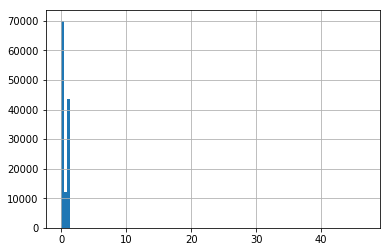

In [39]:
df.FTE.hist(bins=100)

In [40]:
df.Total.isnull().sum()

4555

In [41]:
min(df.Total.fillna(0)), max(df.Total.fillna(0))

(-87466307.15, 129699999.22)

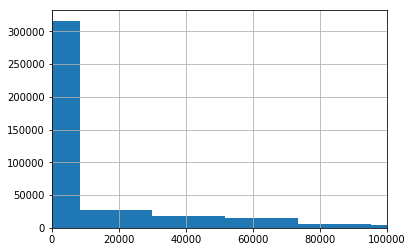

In [42]:
df.Total.hist(bins=10000)
plt.xlim(0,1e5);